За основу был взят ваш код с семинара, и переписан под сэмплирование Гиббса на питоне

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
from tqdm import tqdm

In [3]:
from numba import jit

In [4]:
@jit(nopython=True)
def ising(L, beta, Time):
    x_p = np.full(L*L, np.nan) # Points for the plot
    y_p = np.full(L*L, np.nan)
    x_m = np.full(L*L, np.nan)
    y_m = np.full(L*L, np.nan)

    sample = np.ones((L,L)) # initial sample

    #random initial condition
    for i in range(L):
        for j in range(L):
            if np.random.random(1) < 0.5:
                sample[i,j] = - 1
            else:
                sample[i,j] = 1

    def elem(p, q): # periodic boundary condition
        if p == -1:
            p = L - 1
        elif p == L:
            p = 0            
        if q == -1:
            q = L - 1
        elif q == L:
            q = 0
        return sample[p, q]

    def delta_E(i, j): # computing delta_E
        return 2 * (elem(i - 1, j) + elem(i + 1, j) + elem(i, j - 1) + elem(i, j + 1))

    # Mixing chain

    for t in range(4 * Time):            
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        dE = delta_E(i,j)
        prob = np.exp(beta * dE) / (1 + np.exp(beta * dE))
        if prob < np.random.random(1):
            sample[i, j] = -1
        else:
            sample[i, j] = 1
    
    E = 0.0
    
    for i in range(L):
        for j in range(L):
            E+= -sample[i,j] * (elem(i - 1, j) + elem(i + 1, j) + elem(i, j - 1) + elem(i, j + 1))
 
    # Vizualisation
    k = 0
    l = 0

    for i in range(L):
        for j in range(L):
            if sample[i, j] == 1:
                x_p[k] = i
                y_p[k] = j
                k += 1
            else:
                x_m[l] = i
                y_m[l] = j
                l += 1

    x_p = x_p[x_p != np.nan]
    x_m = x_m[x_m != np.nan]
    y_p = y_p[y_p != np.nan]
    y_m = y_m[y_m != np.nan]
    return x_p, y_p, x_m, y_m, E / (L**2)

In [5]:
L = 32 # square lattice L
Time = L*L*L*L # number of steps (set L*L and 500*L*L and L^4)
beta = 0.95 # 1/T, critical value = 0.44 (change: 0.01 -> 0.44 -> 0.95)

In [6]:
from tqdm import tqdm

In [7]:
beta_ = np.linspace(0.01, 0.95, 100)
E_ = []
for beta in tqdm(beta_):
    x_p, y_p, x_m, y_m, E = ising(L, beta, Time)
    E_.append(E)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


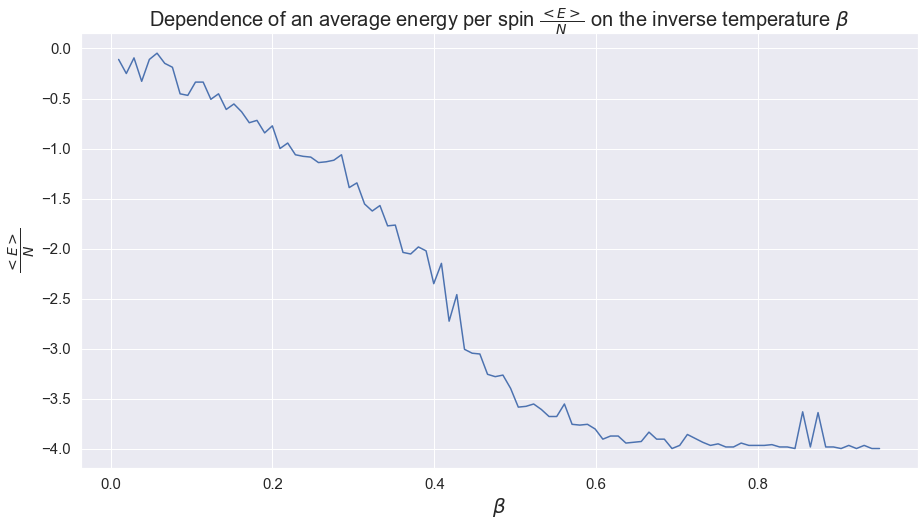

In [8]:
plt.figure(figsize = (15,8))
plt.plot(beta_, E_)
plt.xlabel(r'$\beta$', fontsize = 20)
plt.ylabel(r'$\frac{<E>}{N}$', fontsize = 20)
plt.title(r'Dependence of an average energy per spin $\frac{<E>}{N}$ on the inverse temperature $\beta$', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

По графику можно предположить, что критическая температура находится вблизи $\beta$ = 0.45
Теперь нарисуем типичные состояния при различных температурах.
Учтем, что при больших $\beta$ кроме состояний с одинаково направленными спинами существуют состояния, которые застряли в локальном минимуме и образовали домен. Нарисуем и тот и другой.

In [9]:
def ising_plot(x_p, y_p, x_m, y_m, L):
    plt.figure(figsize = (15,10))
    plt.xlim(-0.5, L - 0.5)
    plt.ylim(-0.5, L - 0.5)
    plt.scatter(x_m, y_m, color = "red", s = 2.5 * L)
    plt.scatter(x_p, y_p, color = "blue", s = 2.5 * L)
    plt.title("The Ising Model, beta = " + str(beta), fontsize = 15)
    plt.xticks(np.arange(0, L, 2), fontsize = 15)
    plt.yticks(np.arange(0, L, 2), fontsize = 15)
    plt.show()

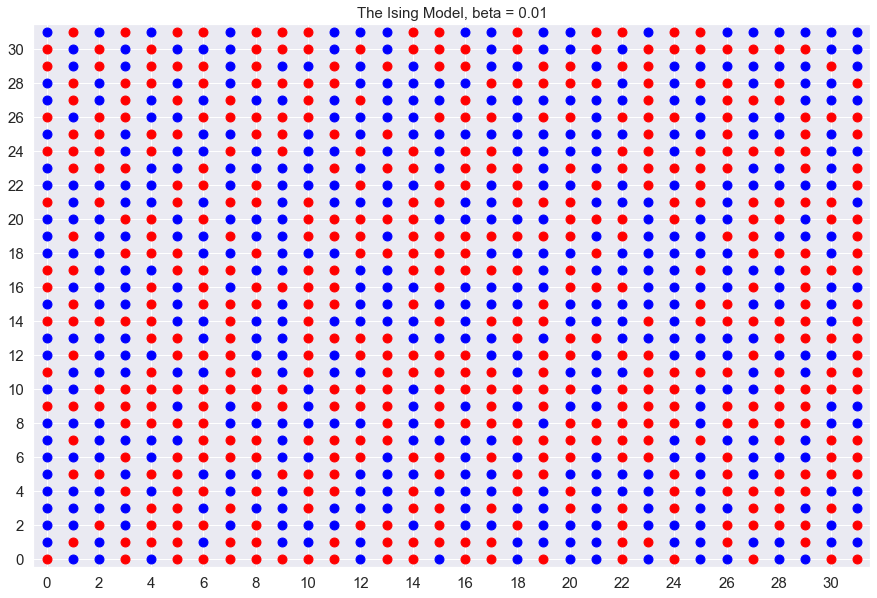

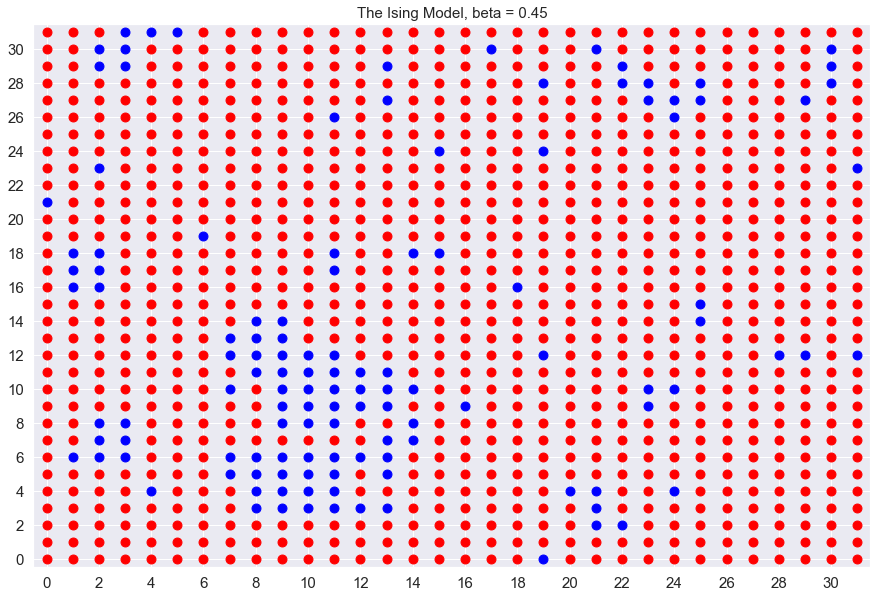

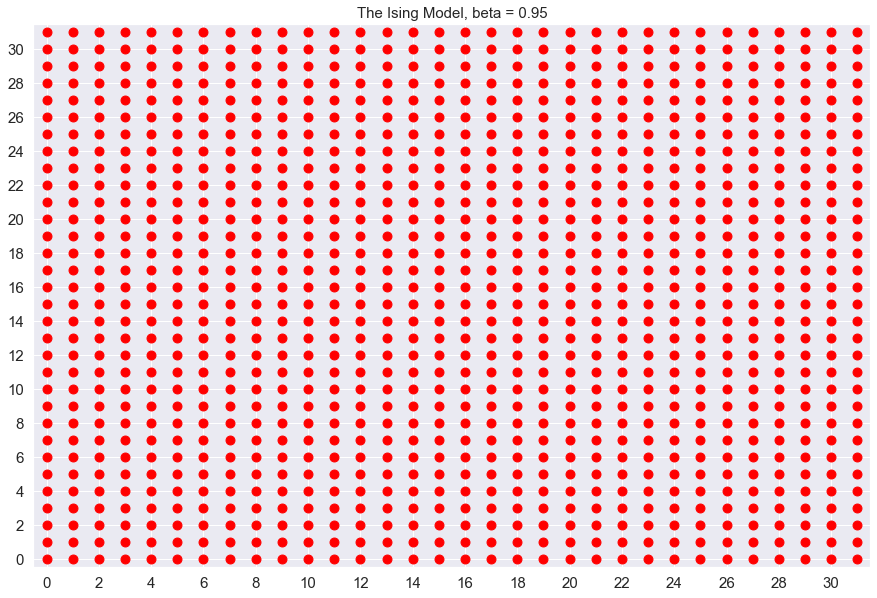

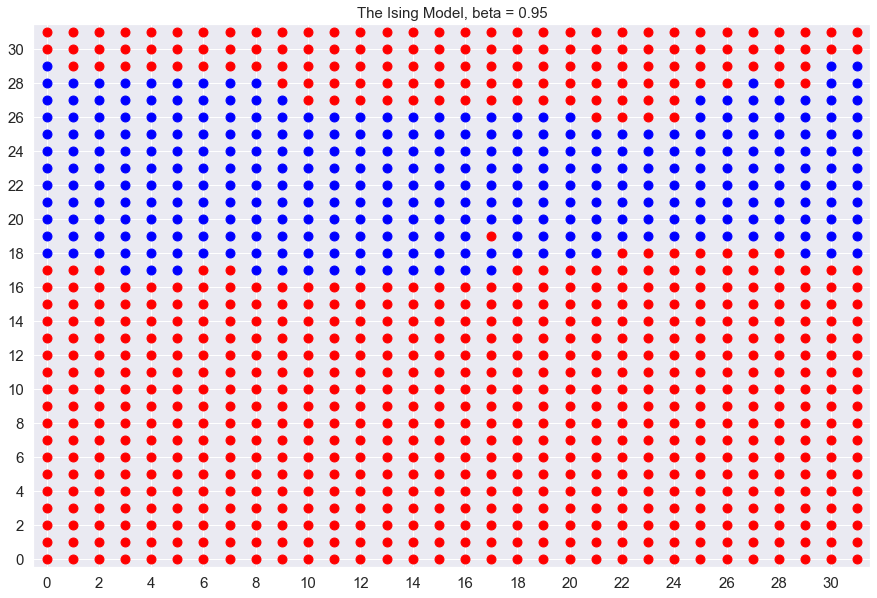

In [10]:
for beta in [0.01, 0.45, 0.95]:
    if beta == 0.95:
        x_p, y_p, x_m, y_m, E = ising(L, beta, Time)
        ising_plot(x_p, y_p, x_m, y_m, L = L)
        if E < -3.7:
            E_n = E
            while E_n < -3.7:
                x_p, y_p, x_m, y_m, E_n = ising(L, beta, Time)
            ising_plot(x_p, y_p, x_m, y_m, L = L)
        else:
            while E > -3.7:
                x_p, y_p, x_m, y_m, E = ising(L, beta, Time)
            ising_plot(x_p, y_p, x_m, y_m, L = L)
    else:
        x_p, y_p, x_m, y_m, E = ising(L, beta, Time)
        ising_plot(x_p, y_p, x_m, y_m, L = L)

Как видим, действительно есть два разных варианта при $\beta$ > $\beta_c$